<a href="https://colab.research.google.com/github/diegooo9/mat281_portfolio_2022/blob/master/Copia_de_hw_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/fralfaro/MAT281_2022/blob/main/homeworks/h2/hw_02.ipynb
" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Tarea N°02

## Instrucciones

1.- Completa tus datos personales (nombre y rol USM) en siguiente celda.


* __Nombre__: Diego Pinochet Muñoz

* __Rol__: 201710518-6

2.- Debes _subir_ este archivo con tus cambios a tu repositorio personal del curso, incluyendo datos, imágenes, scripts, etc.

3.- Se evaluará:
   - Soluciones
   - Código
   - Al presionar  `Kernel -> Restart Kernel and Run All Cells` deben ejecutarse todas las celdas sin error.

## I.- Clasificación de dígitos


En este laboratorio realizaremos el trabajo de reconocer un dígito a partir de una imagen.


![rgb](https://www.wolfram.com/language/11/neural-networks/assets.en/digit-classification/smallthumb_1.png)

El objetivo es a partir de los datos, hacer la mejor predicción de cada imagen. Para ellos es necesario realizar los pasos clásicos de un proyecto de _Machine Learning_, como estadística descriptiva, visualización y preprocesamiento. 

* Se solicita ajustar al menos tres modelos de clasificación:
 * Regresión logística
 * K-Nearest Neighbours 
 * Uno o más algoritmos a su elección [link](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning) (es obligación escoger un _estimator_ que tenga por lo menos un hiperparámetro). 
 
 
* En los modelos que posean hiperparámetros es mandatorio buscar el/los mejores con alguna técnica disponible en `scikit-learn` ([ver más](https://scikit-learn.org/stable/modules/grid_search.html#tuning-the-hyper-parameters-of-an-estimator)).
* Para cada modelo, se debe realizar _Cross Validation_ con 10 _folds_ utilizando los datos de entrenamiento con tal de determinar un intervalo de confianza para el _score_ del modelo.
* Realizar una predicción con cada uno de los tres modelos con los datos _test_ y obtener el _score_. 
* Analizar sus métricas de error (**accuracy**, **precision**, **recall**, **f-score**)



### Exploración de los datos
A continuación se carga el conjunto de datos a utilizar, a través del sub-módulo `datasets` de `sklearn`.

In [114]:
import numpy as np
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import time
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import  KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from numpy import interp
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score


%matplotlib inline

In [28]:
digits_dict = datasets.load_digits()
print(digits_dict["DESCR"])

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 1797
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

In [29]:
digits_dict.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [30]:
digits_dict["target"]

array([0, 1, 2, ..., 8, 9, 8])

A continuación se crea dataframe declarado como `digits` con los datos de `digits_dict` tal que tenga 65 columnas, las 6 primeras a la representación de la imagen en escala de grises (0-blanco, 255-negro) y la última correspondiente al dígito (`target`) con el nombre _target_.

In [31]:
digits = (
    pd.DataFrame(
        digits_dict["data"],
    )
    .rename(columns=lambda x: f"c{x:02d}")
    .assign(target=digits_dict["target"])
    .astype(int)
)

digits.head()

,c00,c01,c02,c03,c04,c05,c06,c07,c08,c09,...,c55,c56,c57,c58,c59,c60,c61,c62,c63,target
0,0,0,5,13,9,1,0,0,0,0,...,0,0,0,6,13,10,0,0,0,0
1,0,0,0,12,13,5,0,0,0,0,...,0,0,0,0,11,16,10,0,0,1
2,0,0,0,4,15,12,0,0,0,0,...,0,0,0,0,3,11,16,9,0,2
3,0,0,7,15,13,1,0,0,0,8,...,0,0,0,7,13,13,9,0,0,3
4,0,0,0,1,11,0,0,0,0,0,...,0,0,0,0,2,16,4,0,0,4


### Ejercicio 1
**Análisis exploratorio:** Realiza tu análisis exploratorio, no debes olvidar nada! Recuerda, cada análisis debe responder una pregunta.

Algunas sugerencias:

* ¿Cómo se distribuyen los datos?
* ¿Cuánta memoria estoy utilizando?
* ¿Qué tipo de datos son?
* ¿Cuántos registros por clase hay?
* ¿Hay registros que no se correspondan con tu conocimiento previo de los datos?

In [32]:
print(f"Sus valores nulos son: {digits.isna().all().unique()}")
print(f"Tipo de dato; {digits.dtypes.unique()}")
print(f'Cantidad de memoria usada en el DataFrame: {digits.memory_usage(index=True,deep=True).sum()} bytes')

Sus valores nulos son: [False]
Tipo de dato; [dtype('int64')]
Cantidad de memoria usada en el DataFrame: 934568 bytes


Obtenemos la correlacion existente entre cada par de columnas:

In [33]:
digits.corr(method="pearson")

,c00,c01,c02,c03,c04,c05,c06,c07,c08,c09,...,c55,c56,c57,c58,c59,c60,c61,c62,c63,target
c00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
c01,NaN,1.000000,0.556618,0.207814,-0.018761,0.060776,0.048388,-0.038927,0.032320,0.556372,...,-0.045342,-0.007905,0.855610,0.555727,0.147646,-0.102349,-0.029870,0.026547,-0.043889,-0.051834
c02,NaN,0.556618,1.000000,0.560180,-0.084235,0.043569,0.002841,-0.062278,0.022311,0.582259,...,-0.003804,-0.025837,0.515276,0.937623,0.499840,-0.134754,-0.041183,0.072599,0.082523,-0.011836
c03,NaN,0.207814,0.560180,1.000000,0.023938,-0.171377,-0.115732,-0.040139,0.035663,0.328344,...,0.075335,-0.049085,0.175804,0.560326,0.767945,-0.065957,-0.054936,0.053437,0.081971,-0.011489
c04,NaN,-0.018761,-0.084235,0.023938,1.000000,0.507731,0.127764,0.010065,0.042065,0.051657,...,-0.212220,0.017352,-0.047223,-0.020176,-0.008867,-0.082125,-0.215809,-0.250699,-0.215349,0.100801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
c60,NaN,-0.102349,-0.134754,-0.065957,-0.082125,-0.351146,-0.383522,-0.178243,0.048996,-0.000604,...,0.105101,0.005697,-0.117908,-0.207957,0.058390,1.000000,0.609515,0.243305,0.103015,-0.196083
c61,NaN,-0.029870,-0.041183,-0.054936,-0.215809,-0.268818,-0.304111,-0.141174,0.033409,0.071488,...,0.262795,-0.003056,-0.043889,-0.091839,-0.094956,0.609515,1.000000,0.648328,0.261991,-0.079100
c62,NaN,0.026547,0.072599,0.053437,-0.250699,-0.267659,-0.178945,-0.063220,0.020689,0.111569,...,0.511726,-0.011932,0.014557,0.035369,0.006849,0.243305,0.648328,1.000000,0.620428,-0.114007
c63,NaN,-0.043889,0.082523,0.081971,-0.215349,-0.167727,-0.080309,-0.024505,-0.005226,-0.001404,...,0.563989,-0.004625,-0.047089,0.031193,0.099671,0.103015,0.261991,0.620428,1.000000,-0.181929


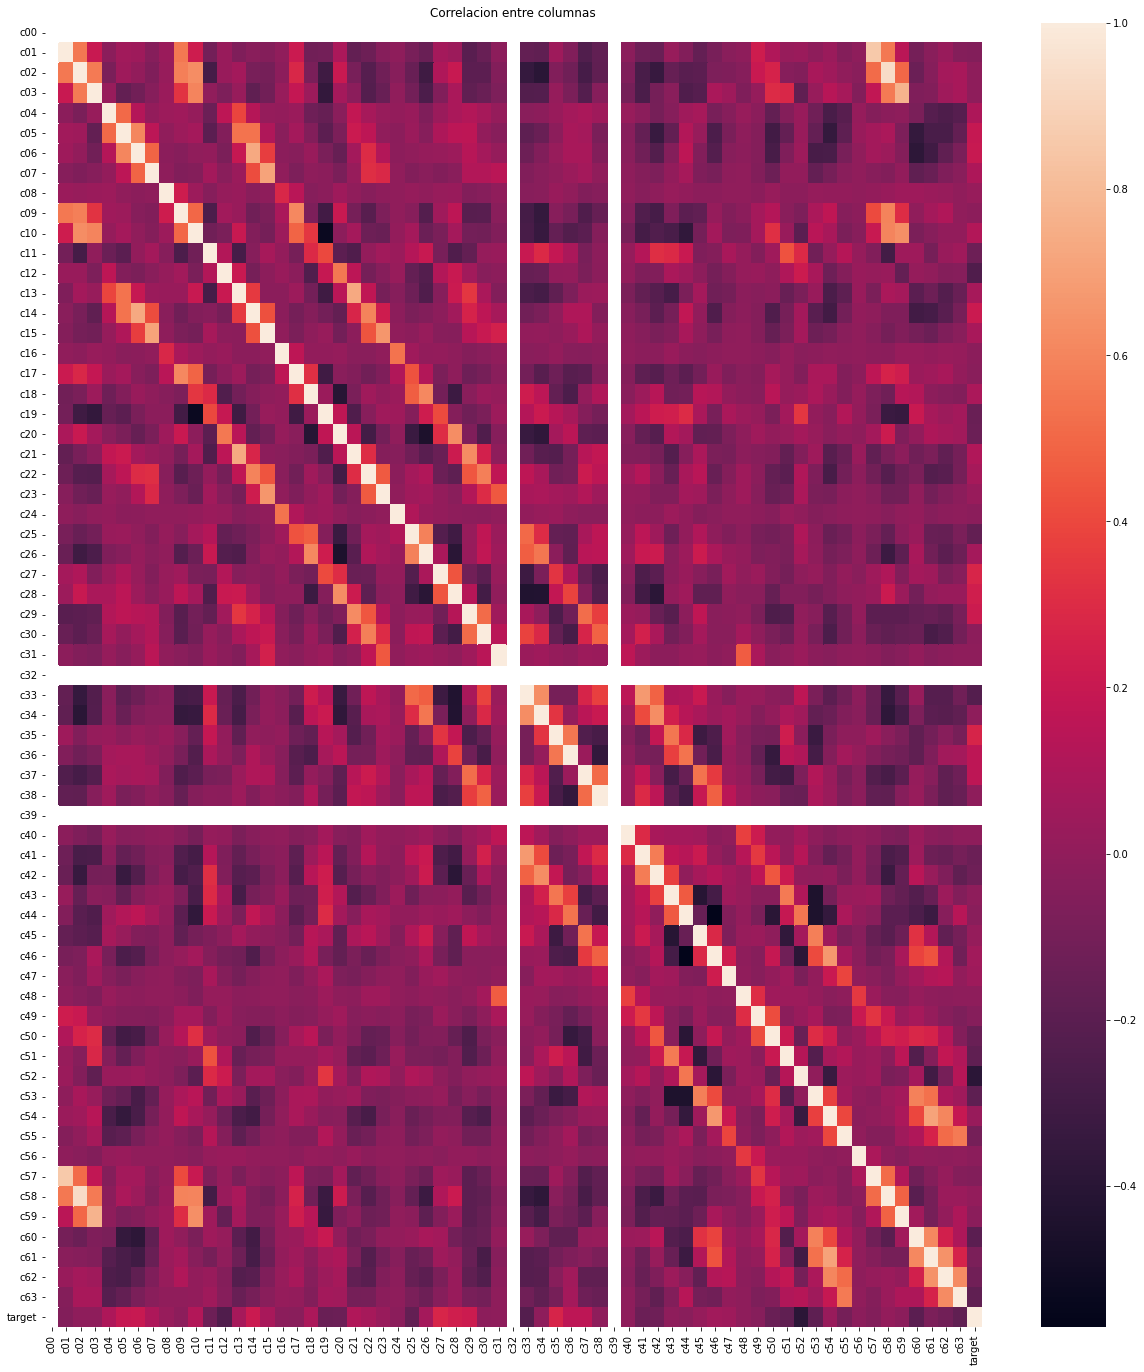

In [34]:
# Heatmap
plt.figure(figsize=(21, 24))
sns.heatmap(digits.corr())
plt.title("Correlacion entre columnas")
plt.show()

In [35]:
targets_count = []

for i in range(len(np.unique(digits['target'].values))):
    print(f'clase {i}')
    print('Descripcion:')
    print(digits[digits['target']==i].describe())
    print('')
    targets_count.append(tuple([i,digits[digits['target']==i].shape[0]]))

print(f"Cantidad de datos asociados a cada clase: {targets_count}")

clase 0
Descripcion:
         c00         c01         c02         c03         c04         c05  \
count  178.0  178.000000  178.000000  178.000000  178.000000  178.000000   
mean     0.0    0.022472    4.185393   13.095506   11.297753    2.926966   
std      0.0    0.211400    2.946684    2.246625    3.417485    3.232996   
min      0.0    0.000000    0.000000    5.000000    0.000000    0.000000   
25%      0.0    0.000000    2.000000   12.000000    9.000000    1.000000   
50%      0.0    0.000000    4.000000   13.000000   12.000000    2.000000   
75%      0.0    0.000000    6.000000   15.000000   14.000000    5.000000   
max      0.0    2.000000   12.000000   16.000000   16.000000   14.000000   

              c06    c07    c08         c09  ...    c55    c56         c57  \
count  178.000000  178.0  178.0  178.000000  ...  178.0  178.0  178.000000   
mean     0.033708    0.0    0.0    0.887640  ...    0.0    0.0    0.005618   
std      0.180985    0.0    0.0    1.778327  ...    0.0    0

Agrupamos el conjunto de datos por el valor de la columna "target" :

In [36]:
digits_group = digits.groupby('target')
digits_group.describe(include='all').T

target         0      1      2      3      4      5      6      7      8  \
c00 count  178.0  182.0  177.0  183.0  181.0  182.0  181.0  179.0  174.0   
    mean     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
    std      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
    min      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
    25%      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
...          ...    ...    ...    ...    ...    ...    ...    ...    ...   
c63 min      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
    25%      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
    50%      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
    75%      0.0    0.0    2.0    0.0    0.0    0.0    0.0    0.0    0.0   
    max      0.0   16.0   16.0    8.0    0.0    0.0    6.0    0.0    2.0   

target         9  
c00 count  180.0  
    mean     0.0  
    std      0.0  
    min      0.0  
    25%      0.0  
...          ...  
c63 min      0.0  
    25%      0.0  
    50%      0.0  
    75%      0.0  
    max      3.0  

[512 rows x 10 columns]

Buscamos observar la distribucion de los datos por cada columna, por lo que hacemos:

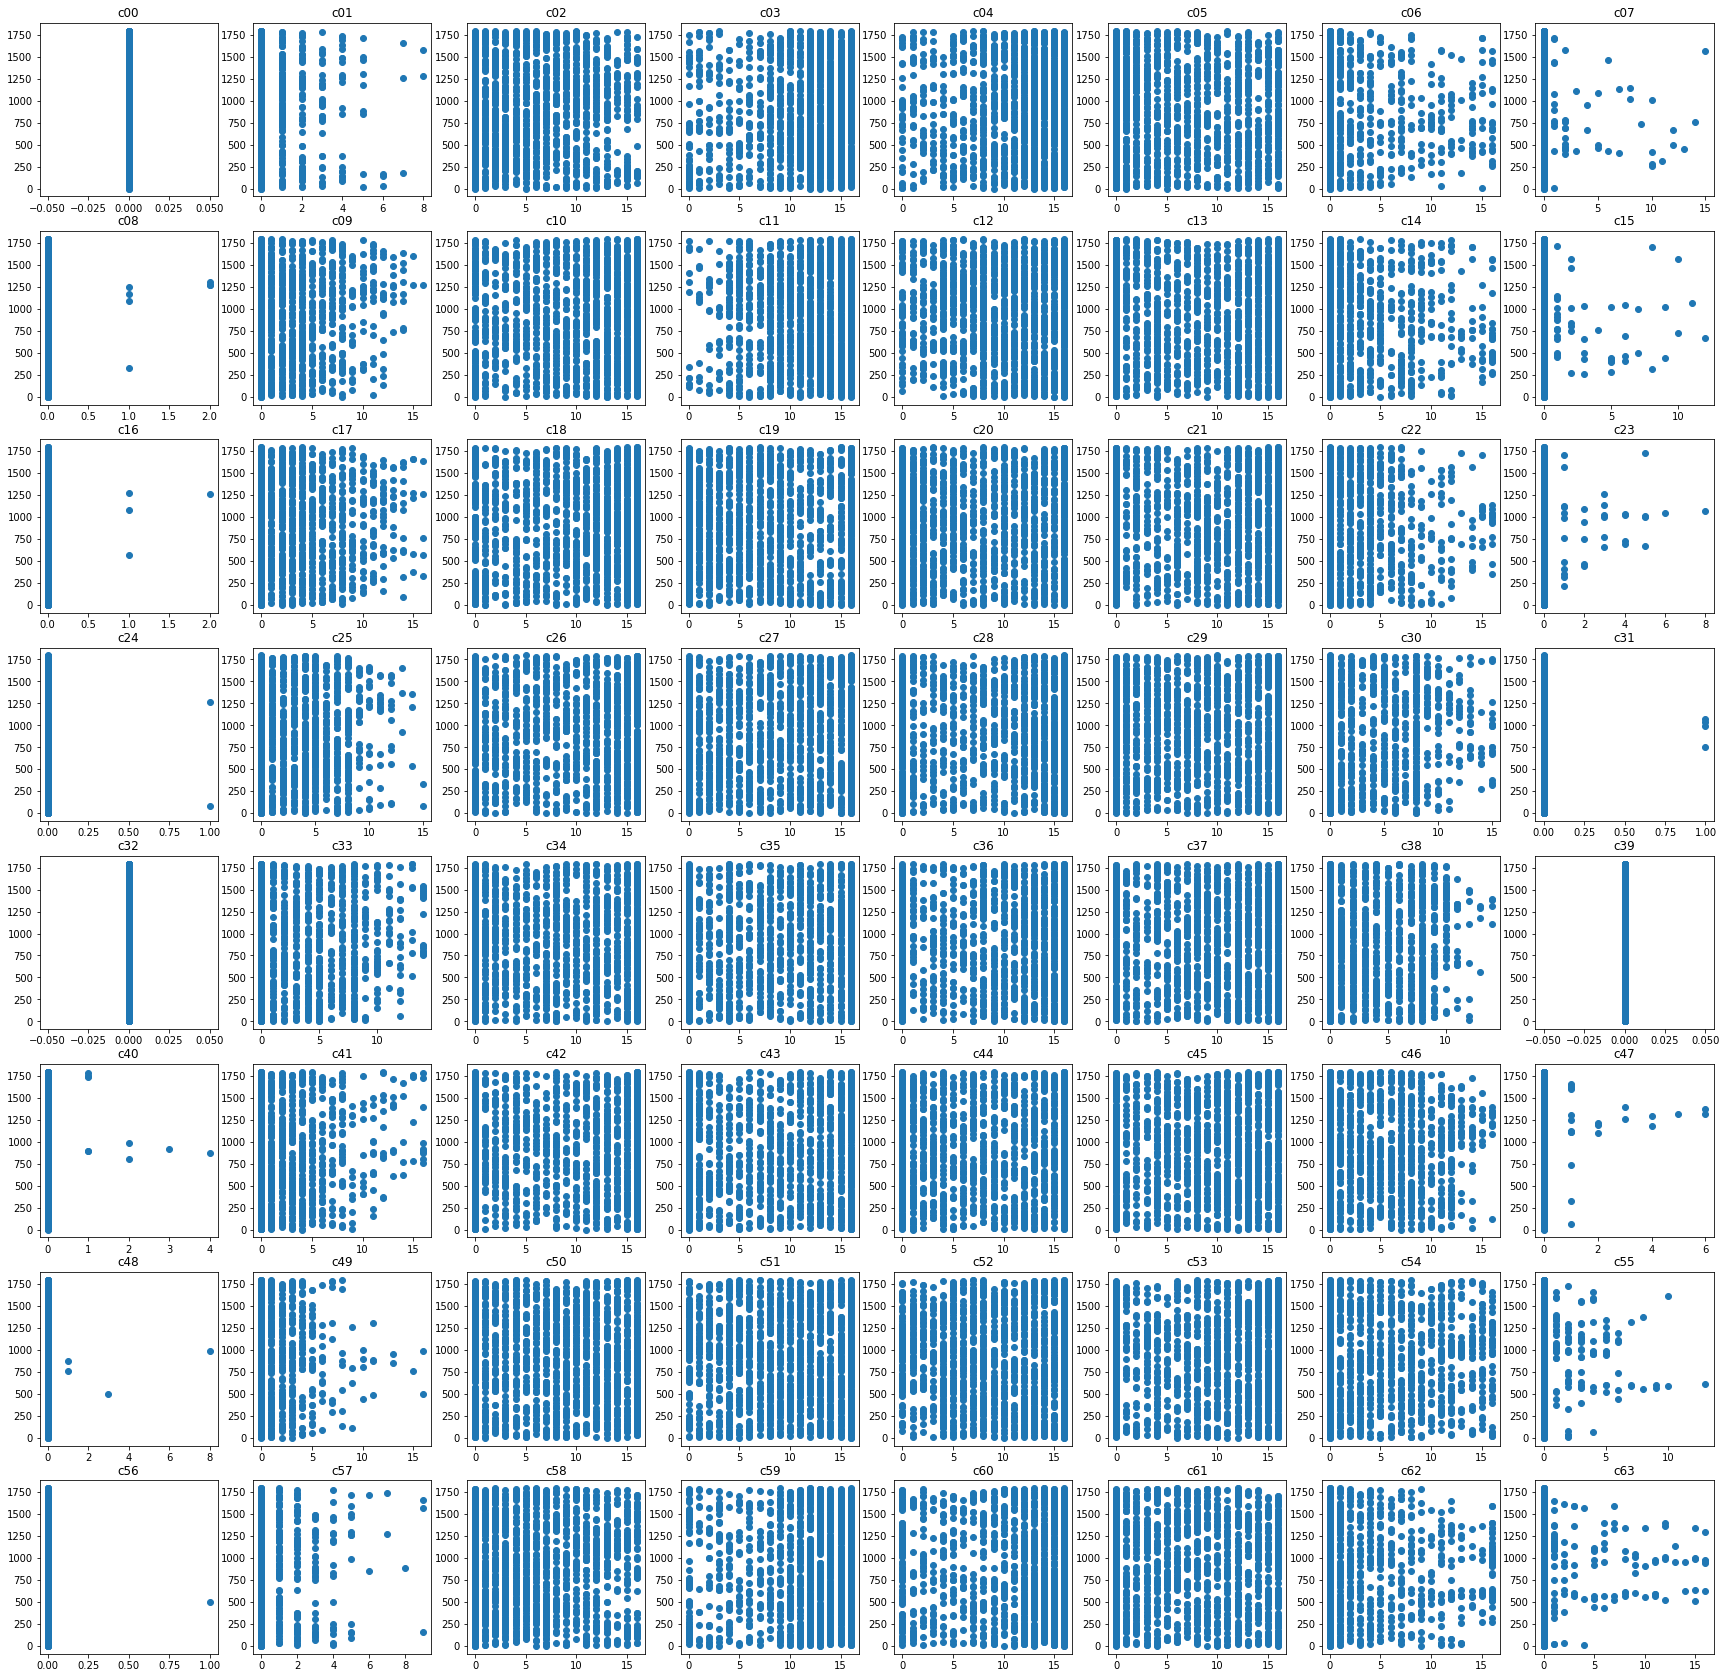

In [37]:
y = [i for i in range(len(digits))]
fig = plt.figure(figsize = (30,30))
for i in range(64):
    plt.subplot(8,8,i+1)
    plt.scatter(digits[digits.columns[i]],y)
    plt.title(digits.columns[i])

### Ejercicio 2
**Visualización:** Para visualizar los datos utilizaremos el método `imshow` de `matplotlib`. Resulta necesario convertir el arreglo desde las dimensiones (1,64)  a (8,8) para que la imagen sea cuadrada y pueda distinguirse el dígito. Superpondremos además el label correspondiente al dígito, mediante el método `text`. Esto nos permitirá comparar la imagen generada con la etiqueta asociada a los valores. Realizaremos lo anterior para los primeros 25 datos del archivo.

In [38]:
digits_dict["images"][0]

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

Visualiza imágenes de los dígitos utilizando la llave `images` de `digits_dict`. 

> **Sugerencia**: Utiliza `plt.subplots` y el método `imshow`. Puedes hacer una grilla de varias imágenes al mismo tiempo!

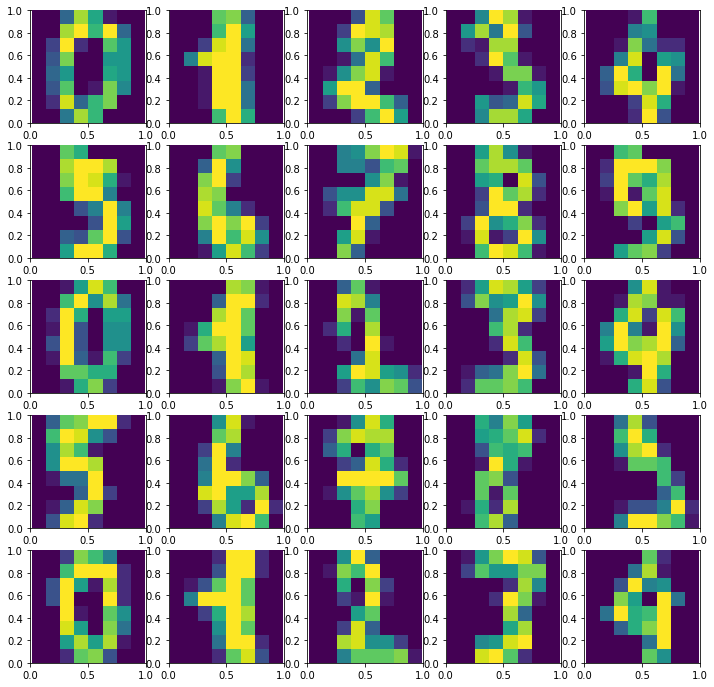

In [39]:
nx, ny = 5, 5
fig, axs = plt.subplots(nx, ny, figsize=(12, 12))
for i in range(1, nx*ny+1):
    img = digits_dict['images'][i-1]
    fig.add_subplot(nx, ny, i)
    plt.imshow(img)
    plt.axis('off')
plt.show()

### Ejercicio 3

**Machine Learning**: En esta parte usted debe entrenar los distintos modelos escogidos desde la librería de `skelearn`. Para cada modelo, debe realizar los siguientes pasos:

* **train-test** 
 * Crear conjunto de entrenamiento y testeo (usted determine las proporciones adecuadas).
 * Imprimir por pantalla el largo del conjunto de entrenamiento y de testeo.
 
 
* **modelo**:
 * Instanciar el modelo objetivo desde la librería sklearn.
 * *Hiper-parámetros*: Utiliza `sklearn.model_selection.GridSearchCV` para obtener la mejor estimación de los parámetros del modelo objetivo.




* **Métricas**:
 * Graficar matriz de confusión.
 * Analizar métricas de error.



__Preguntas a responder:__

* ¿Cuál modelo es mejor basado en sus métricas?
* ¿Cuál modelo demora menos tiempo en ajustarse?
* ¿Qué modelo escoges?


In [40]:
def summary_metrics(df) -> pd.DataFrame:
    """
    Aplicar las distintas metricas definidas
    :param df:  dataframe con las columnas: ['y','yhat']
    :return: dataframe con las metricas especificadas
    """
    df_result = pd.DataFrame()

    y_true = df['y']
    y_pred = df['yhat']

    df_result['accuracy'] = [round(accuracy_score(y_true,y_pred),4)]
    df_result['recall'] = [round(recall_score(y_true,y_pred, average="macro"),4)]
    df_result['precision'] = [round(precision_score(y_true,y_pred, average="macro"),4)]
    df_result['fscore'] = [round(f1_score(y_true,y_pred, average="macro"),4)]


    return df_result

Separamos el conjunto en sus conjuntos de entrenamiento y de testeo:

In [41]:
X = digits.drop(columns="target").values
y = digits["target"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=2)

print(f'numero de filas train set: {len(X_train)}')
print(f'numero de filas test set: {len(X_test)}')


numero de filas train set: 1257
numero de filas test set: 540


Realizamos una regresion logistica:

In [44]:
#Hiperparametros
params_log = {
          'penalty' : [ "l1",'l2'],
          'C' : [100, 10 , 1, 0.1, 0.01,1000],
          'class_weight' : ['balanced', None],
          'solver' : ['liblinear'],
          }
#Regresion logistica
log_model = LogisticRegression()

log_grid = GridSearchCV(estimator = log_model, param_grid = params_log, cv = 10)

start_time = time.time()

log_grid_result = log_grid.fit(X_train, y_train)


print("--- %s segundos ---" % (time.time() - start_time))

print(
    "The best parameters are %s with a score of %0.2f"
    % (log_grid_result.best_params_, log_grid_result.best_score_))


--- 60.0944299697876 segundos ---
The best parameters are {'C': 0.01, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'} with a score of 0.97


In [45]:
y_pred = log_grid_result.predict(X_test)
summary_metrics(pd.DataFrame(data={'y':y_test, 'yhat':y_pred}))

,accuracy,recall,precision,fscore
0,0.9389,0.9374,0.9371,0.937


In [46]:
print('Matriz de confusion:')
pd.DataFrame(data=confusion_matrix(y_test,y_pred))

Matriz de confusion:


,0,1,2,3,4,5,6,7,8,9
0,53,0,0,0,1,0,0,0,0,0
1,0,50,0,1,0,0,1,0,2,2
2,0,0,54,0,0,0,0,0,0,0
3,0,1,0,56,0,2,0,3,0,0
4,0,1,0,0,49,0,0,0,1,2
5,1,1,0,0,0,56,0,0,0,1
6,0,0,0,0,0,0,55,0,1,0
7,0,0,0,0,0,0,0,54,0,1
8,0,4,0,1,0,0,1,0,41,0
9,0,1,0,1,0,0,0,0,3,39


Usamos el modelo del vecino mas cercano con un conjunto de distintos hiperparametros:

In [47]:
#Hiperparametros
params_knn = {
          'n_neighbors' : [5, 3, 8,16,32 ],
          'weights' : ['uniform', 'distance'],
          'metric' : ['euclidean', 'manhattan',"minkowski"],
          'algorithm' : ['auto','ball_tree', 'kd_tree']
          }
#k-vecinos mas cercanos
model_knn = KNeighborsClassifier()


model_kn = GridSearchCV(estimator = model_knn, param_grid = params_knn, cv = 10)

start_time = time.time()
model_kn = model_kn.fit(X_train, y_train)


print("--- %s segundos ---" % (time.time() - start_time))


--- 16.162235021591187 segundos ---


In [48]:
print(
    "The best parameters are %s with a score of %0.2f"
    % (model_kn.best_params_, model_kn.best_score_))
y_pred = model_kn.predict(X_test)
summary_metrics(pd.DataFrame(data={'y':y_test, 'yhat':y_pred}))

The best parameters are {'algorithm': 'auto', 'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'} with a score of 0.99


,accuracy,recall,precision,fscore
0,0.9796,0.979,0.9785,0.9785


In [49]:
print('Matriz de confusion:')
pd.DataFrame(data=confusion_matrix(y_test,y_pred))

Matriz de confusion:


,0,1,2,3,4,5,6,7,8,9
0,54,0,0,0,0,0,0,0,0,0
1,0,56,0,0,0,0,0,0,0,0
2,0,0,54,0,0,0,0,0,0,0
3,0,0,0,59,0,0,0,1,1,1
4,0,0,0,0,50,0,0,1,1,1
5,0,0,0,0,0,58,0,0,0,1
6,0,0,0,0,0,0,56,0,0,0
7,0,0,0,0,0,0,0,55,0,0
8,0,2,0,0,0,0,0,0,45,0
9,0,0,0,0,0,0,0,1,1,42


In [50]:
#Escalamos los conjuntos "X" de testeo y de entrenamiento
scaler = StandardScaler()
X_train2 = scaler.fit_transform(X_train)
X_test2= scaler.fit_transform(X_test)

#SVM con kernel lineal
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=10)
start_time=time.time()
grid.fit(X_train2, y_train)

print("---%s segundos---"% (time.time()- start_time))
print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)

---207.57959008216858 segundos---
The best parameters are {'C': 10000.0, 'gamma': 0.0001} with a score of 0.98


In [51]:
y_pred = grid.predict(X_test2)
summary_metrics(pd.DataFrame(data={'y':y_test, 'yhat':y_pred}))

,accuracy,recall,precision,fscore
0,0.9704,0.9684,0.9688,0.9683


In [52]:
print('Matriz de confusion:')
pd.DataFrame(data=confusion_matrix(y_test,y_pred))

Matriz de confusion:


,0,1,2,3,4,5,6,7,8,9
0,54,0,0,0,0,0,0,0,0,0
1,0,56,0,0,0,0,0,0,0,0
2,0,0,54,0,0,0,0,0,0,0
3,0,0,0,60,0,0,0,0,1,1
4,0,0,0,0,49,0,0,0,3,1
5,0,0,0,0,0,57,0,0,0,2
6,0,0,0,0,0,0,56,0,0,0
7,0,0,0,0,0,0,0,55,0,0
8,0,4,0,0,0,0,1,0,42,0
9,0,0,0,1,0,1,0,1,0,41


AL visualizar las metricas otorgadas por cada modelo, en particular "accuracy" y "fscore", podemos concluir que el modelo que mejor se ajusta y predice es "k-vecinos mas cercanos".

### Ejercicio 4

__Comprensión del modelo:__ Tomando en cuenta el mejor modelo entontrado en el `Ejercicio 3`, debe comprender e interpretar minuciosamente los resultados y gráficos asocados al modelo en estudio, para ello debe resolver los siguientes puntos:



 * **Cross validation**: usando **cv** (con n_fold = 10), sacar una especie de "intervalo de confianza" sobre alguna de las métricas estudiadas en clases: 
  * $\mu \pm \sigma$ = promedio $\pm$ desviación estandar
 * **Curva de Validación**: Replica el ejemplo del siguiente [link](https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html#sphx-glr-auto-examples-model-selection-plot-validation-curve-py) pero con el modelo, parámetros y métrica adecuada. Saque conclusiones del gráfico.
 * **Curva AUC–ROC**: Replica el ejemplo del siguiente  [link](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py) pero con el modelo, parámetros y métrica adecuada. Saque conclusiones del gráfico.

Cross validation:

In [53]:
accuracy = cross_val_score(estimator=model_kn,
                            X=X_train,
                            y=y_train,
                            cv=10,
                            scoring="accuracy")
print(accuracy)
mean_score = accuracy.mean()
std_score = accuracy.std()
from IPython.display import display, Math
(display(Math(r'accuracy\: {0: .3f} \pm {1: .3f}'.format(mean_score,std_score))))


[0.98412698 1.         1.         0.97619048 0.99206349 0.98412698
 0.97619048 0.984      0.984      0.992     ]


<IPython.core.display.Math object>

Validation curve:

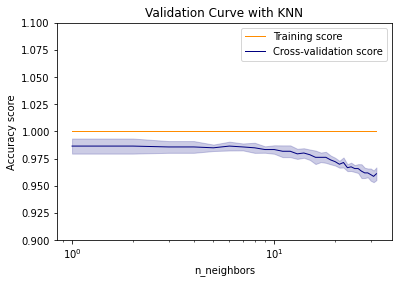

In [55]:
param_range = np.arange(1,33,1)
# Usamos los mejores hiperparametros 
train_scores, test_scores = validation_curve(
    KNeighborsClassifier(weights = 'distance',metric = 'euclidean'), X_train, y_train, param_name="n_neighbors", param_range=param_range,
    scoring="accuracy", n_jobs=1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with KNN")
plt.xlabel("n_neighbors")
plt.ylabel("Accuracy score")
plt.ylim(0.9, 1.1)

lw = 1
plt.semilogx(param_range, train_scores_mean, label="Training score",color="darkorange", lw=lw)

plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,color="darkorange", lw=lw)

plt.semilogx(param_range, test_scores_mean, 
             label="Cross-validation score",color="navy", lw=lw)

plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,color="navy", lw=lw)

plt.legend(loc="best")

plt.show()



Como bien sabemos esta curva nos permite apreciar si es que se presenta un overfitting o underfitting en el modelo. De aqui es distinguible que si ocurre esto, ya que el valor que mejor se ajusta al modelo como hiperparametro de numero de vecinos es de 3, lo cual es inusual; ademas la curva a medida que aumenta este hiperparametro desciende su "accuracy score". En sintesis, el modelo se ajusta solamente al conjunto de entrenamiento, por lo que este no esta aprendiendo.

Realizamos la curva AUC-ROC

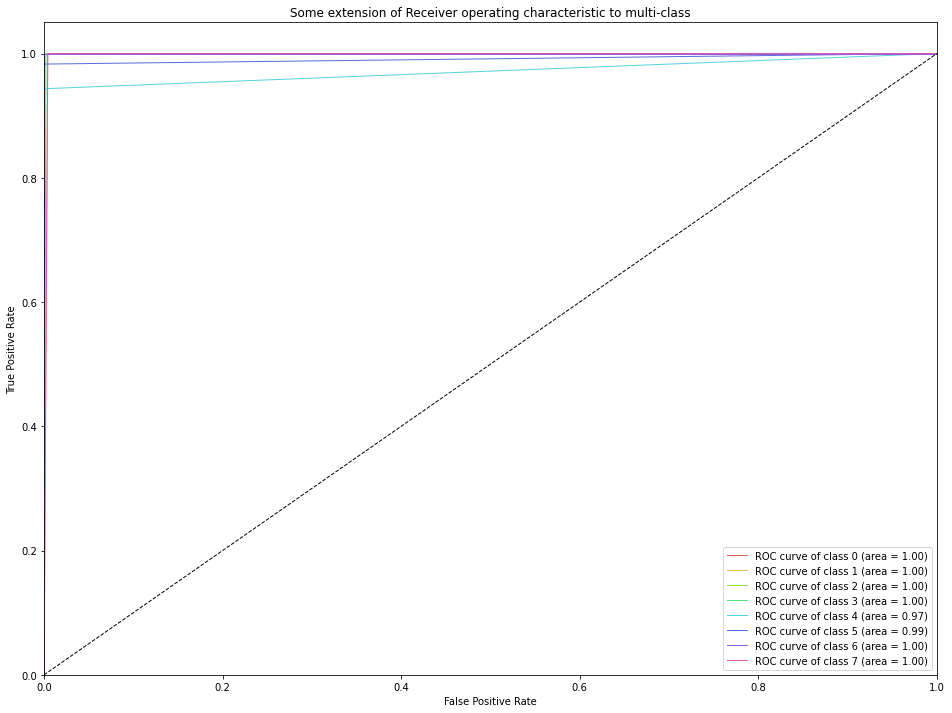

In [56]:
y = label_binarize(y, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
n_classes = y.shape[1]

n_samples, n_features = X.shape

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)

classifier = KNeighborsClassifier(algorithm='auto', metric='euclidean', n_neighbors=2, weights='distance')
y_score = classifier.fit(X_train, y_train).predict(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.rcParams["figure.figsize"] = (16,12)
colors = sns.color_palette("hls", 8)
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()


De aqui se desprende que el modelo usado predice bastante bien, pues sus valores de "False positive rate" son cero o cercanos a este, mientras que sus valores de "True positive rate" tienden a 1.

### Ejercicio 5
__Reducción de la dimensión:__ Tomando en cuenta el mejor modelo encontrado en el `Ejercicio 3`, debe realizar una redcción de dimensionalidad del conjunto de datos. Para ello debe abordar el problema ocupando los dos criterios visto en clases:  

* **Selección de atributos**
* **Extracción de atributos**

__Preguntas a responder:__

Una vez realizado la reducción de dimensionalidad, debe sacar algunas estadísticas y gráficas comparativas entre el conjunto de datos original y el nuevo conjunto de datos (tamaño del dataset, tiempo de ejecución del modelo, etc.)


In [81]:
Xl= pd.DataFrame(digits.drop(columns="target")) 
columnas = list(Xl.columns.values)
Xl = StandardScaler().fit_transform(Xl)
pca = PCA(n_components=25)
principalComponents = pca.fit_transform(Xl)
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(principalComponents, y, test_size=0.3, random_state=2)


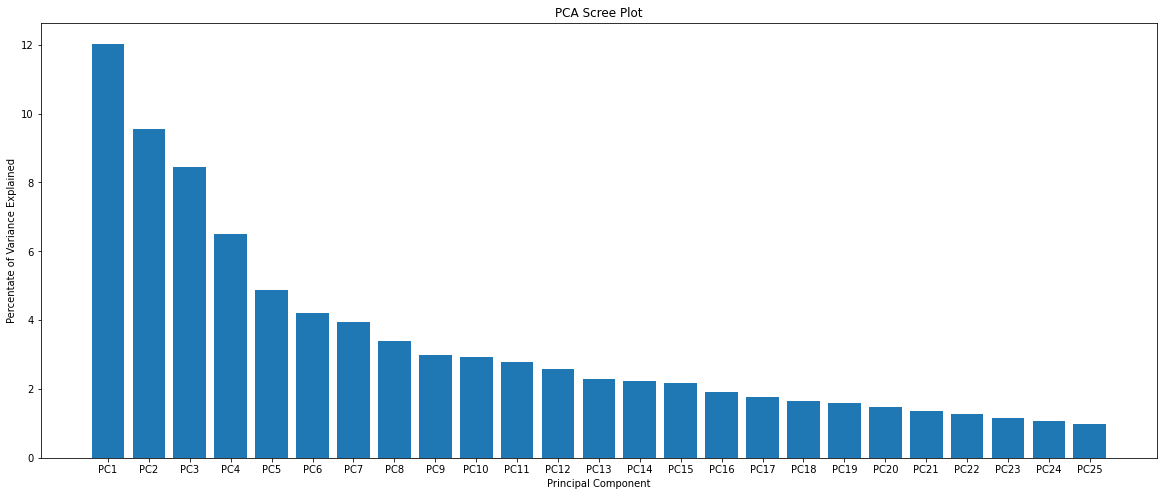

In [82]:
percent_variance = np.round(pca.explained_variance_ratio_* 100, decimals =2)
columns=[]
for i in range(1,26 ):
    if i == 1:
        columns.append(f'PC{i}')
    else:
        columns.append(f'PC{i}')
    columns

plt.figure(figsize=(20,8))
plt.bar(x= range(1,26), height=percent_variance, tick_label=columns)
plt.ylabel('Percentate of Variance Explained')
plt.xlabel('Principal Component')
plt.title('PCA Scree Plot')
plt.show()


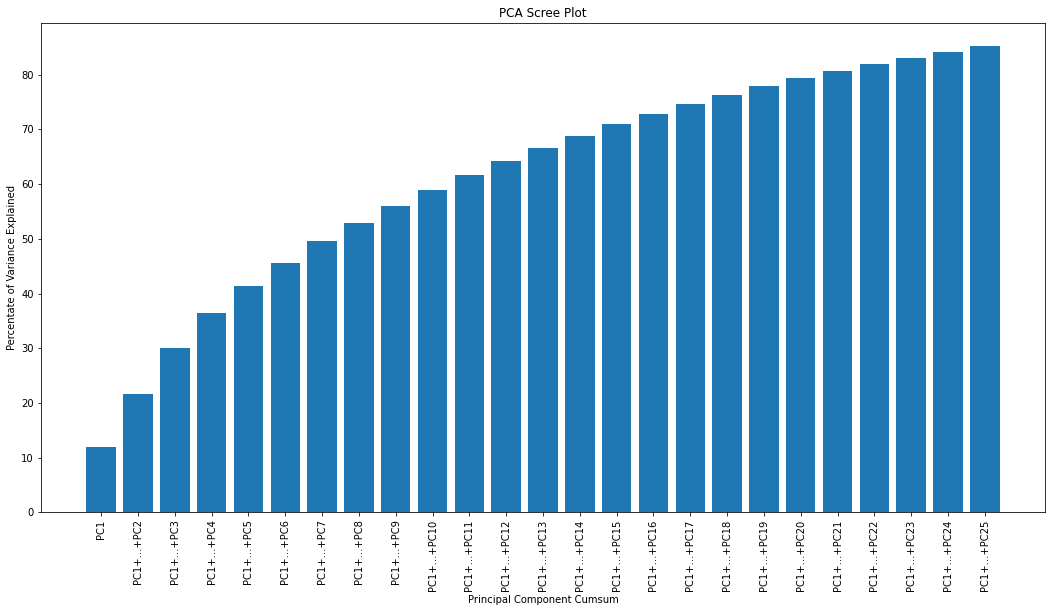

In [83]:
percent_variance_cum = np.cumsum(percent_variance)
columns = []
for i in range(1, 26):
    if i == 1:
        columns.append(f'PC{i}')
    else:
        columns.append(columns[0] + f'+...+PC{i}')
columns

plt.figure(figsize=(18,9))
plt.bar(x= range(1,26), height=percent_variance_cum, tick_label=columns)
plt.ylabel('Percentate of Variance Explained')
plt.xticks(x= range(1,26), rotation='vertical')
plt.xlabel('Principal Component Cumsum')
plt.title('PCA Scree Plot')
plt.show()

In [94]:
params_knn = {
          'n_neighbors' : [5, 3, 8,16,32 ],
          'weights' : ['uniform', 'distance'],
          'metric' : ['euclidean', 'manhattan',"minkowski"],
          'algorithm' : ['auto','ball_tree', 'kd_tree']
          }

model_knn = KNeighborsClassifier()

model_knn = GridSearchCV(estimator = model_knn, param_grid = params_knn, cv = 10)

start_time = time.time()

model_knn_grid = model_knn.fit(X_train_pca, y_train_pca)

print('KNN with selected attributes')
print("--- %s segundos ---" % (time.time() - start_time))


KNN with selected attributes
--- 23.760637760162354 segundos ---


In [95]:
accuracy = cross_val_score(estimator=model_knn,
                            X=X_train_pca,
                            y=y_train_pca,
                            cv=10,
                            scoring="accuracy")
print(accuracy)
mean_score = accuracy.mean()
std_score = accuracy.std()
from IPython.display import display, Math
(display(Math(r'accuracy\: {0: .3f} \pm {1: .3f}'.format(mean_score,std_score))))


[0.97619048 1.         0.96825397 0.95238095 0.98412698 0.96825397
 0.96031746 0.976      0.976      0.984     ]


<IPython.core.display.Math object>

Podemos notar que al intentar reducir la dimensionalidad y hacer el problema mas simple se produjo una disminucion de la metrica "accuracy", sin embargo es un pequeño cambio, mientras que la muestra luego del PCA yace mas dispersa.

### Ejercicio 6


__Visualizando Resultados:__ A continuación se provee código para comparar las etiquetas predichas vs las etiquetas reales del conjunto de _test_. 


In [93]:
def mostar_resultados(digits,model,nx=5, ny=5,label = "correctos"):
    """
    Muestra los resultados de las prediciones de un modelo 
    de clasificacion en particular. Se toman aleatoriamente los valores
    de los resultados.
    
    - label == 'correcto': retorna los valores en que el modelo acierta.
    - label == 'incorrecto': retorna los valores en que el modelo no acierta.

    
    Observacion: El modelo que recibe como argumento debe NO encontrarse
    'entrenado'.
    
    
    :param digits: dataset 'digits'
    :param model: modelo de sklearn
    :param nx: numero de filas (subplots)
    :param ny: numero de columnas (subplots)
    :param label: datos correctos o incorrectos
    :return: graficos matplotlib
    """
    
    
    X = digits.drop(columns="target").values
    y = digits["target"].values
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state = 42) 
    model.fit(X_train, Y_train) # ajustando el modelo
    y_pred = np.array(model.predict(X_test))

    
    # Mostrar los datos correctos
    if label=="correctos":
        mask = (y_pred == Y_test)
        color = "green"
        
    # Mostrar los datos correctos
    elif label=="incorrectos":
        mask = (y_pred != Y_test)
        color = "red"
    
    else:
        raise ValueError("Valor incorrecto")
        
    X_aux = X_test[mask]
    y_aux_true = Y_test[mask]
    y_aux_pred = np.array(y_pred[mask])

    # We'll plot the first 100 examples, randomly choosen
    fig, ax = plt.subplots(nx, ny, figsize=(12,12))
    for i in range(nx):
        for j in range(ny):
            index = j + ny * i
            if index < X_aux.shape[0]:
              data  = X_aux[index, :].reshape(8,8)
              label_pred = str(int(y_aux_pred[index]))
              label_true = str(int(y_aux_true[index]))
              ax[i][j].imshow(data, interpolation='nearest', cmap='gray_r')
              ax[i][j].text(0, 0, label_pred, horizontalalignment='center', verticalalignment='center', fontsize=10, color=color)
              ax[i][j].text(7, 0, label_true, horizontalalignment='center', verticalalignment='center', fontsize=10, color='blue')
              ax[i][j].get_xaxis().set_visible(False)
              ax[i][j].get_yaxis().set_visible(False)
    plt.show()

**Pregunta**

* Tomando en cuenta el mejor modelo entontrado en el `Ejercicio 3`, grafique los resultados cuando:
 * el valor predicho y original son iguales
 * el valor predicho y original son distintos 


* Cuando el valor predicho y original son distintos ,  ¿Por qué ocurren estas fallas?

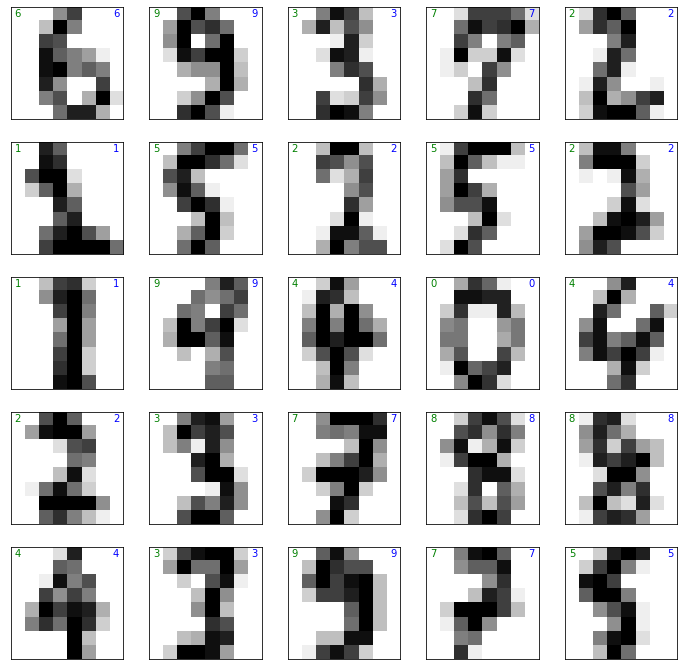

In [96]:
mostar_resultados(digits, KNeighborsClassifier(), nx=5, ny=5, label = "correctos")


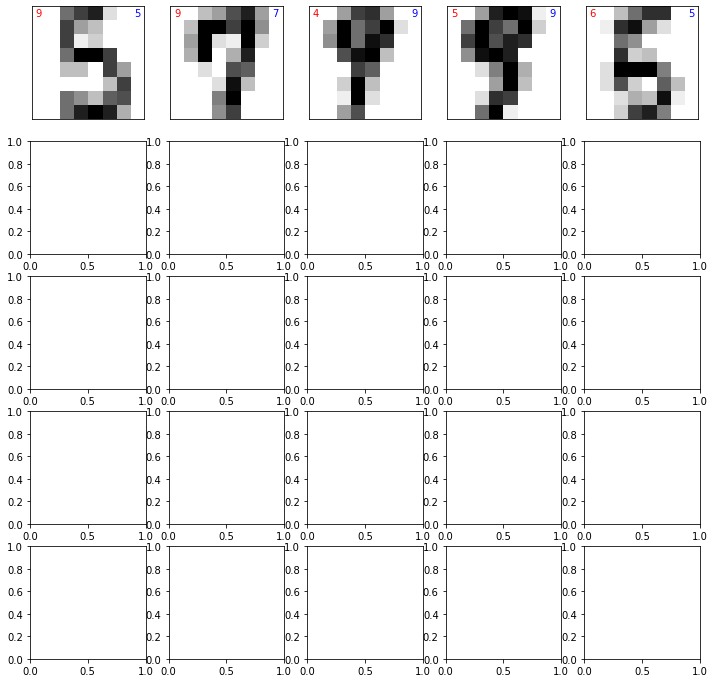

In [97]:
mostar_resultados(digits, KNeighborsClassifier(), nx=5, ny=5, label = "incorrectos")


Estas fallas ocurren por la mala calidad de ciertos datos que provocan una imagen confusa.

### Ejercicio 7
**Conclusiones**: Entrega tu veredicto, responde las preguntas iniciales, visualizaciones, trabajos futuros, dificultades, etc.

## II.- California Housing Prices


<img src="https://www.wartsila.com/images/default-source/default-album/california_housing.tmb-1920x690.jpg?sfvrsn=126bc44_1" width="480" height="240" align="center"/>

Los datos se refieren a las casas encontradas en un distrito determinado de California y algunas estadísticas resumidas sobre ellas basadas en los datos del censo de 1990. Tenga en cuenta que los datos no se limpian, por lo que se requieren algunos pasos de procesamiento previo.

Las columnas son las siguientes, sus nombres se explican por sí mismos:

* longitude
* latitude
* housingmedianage
* total_rooms
* total_bedrooms
* population
* households
* median_income
* medianhousevalue
* ocean_proximity


El objetivo es poder predecir el valor promedio de cada propiedad. 
Para poder completar correctamente este laboratorio, es necesario seguir la siguiente rúbrica de trabajo:

1. Definición del problema
2. Estadística descriptiva
3. Visualización descriptiva
4. Preprocesamiento
5. Selección de modelo 
    1. Por lo menos debe comparar cuatro modelos
    2. Al menos tres de estos modelos tienen que tener hiperparámetros.
    3. Realizar optimización de hiperparámetros.
6. Métricas y análisis de resultados
7. Visualizaciones del modelo
8. Conclusiones

> **Observación**: Puede tomar como referencia lo realizado en la sección **I.- Clasificación de dígitos**. El alumno tiene la libertad de desarrollar un análisis más completo del problema (si así lo desea). Puede tomar como referencia el siguiente [link](https://www.kaggle.com/camnugent/california-housing-prices).

Transversalmente a todos los animales, surge la necesidad de una residencia o refugio, lo cual con el surgimiento de la sociedad humana y una de sus herramientas: La economia; se pudo explotar y estructurar tal idea.
Con el paso de los años y dependiendo de como va la economia, los precios de los bienes y servicios van variando, en particular, suelen ser crecientes. El conjunto de la necesidad de un hogar con el anhelo de mantener a flote los activos de uno, presenta una necesidad de vigilar o estudiar los precios de las viviendas, para asi gestionar de manera optima los recursos y obtener un nivel de satisfaccion predeterminado. 
Es aqui donde se presenta el conjunto de datos a estudiar, donde cada registro indica una de las casas pertenecientes a un distrito del estado de California, EEUU. Se presentan ciertas propiedades o plus valias de las residencias en cuestion, las cuales se indican en cada columna y que tienen como nombres:

-longitude

-latitude

-housingmedianage

-total_rooms

-total_bedrooms

-population

-households

-median_income

-medianhousevalue

-ocean_proximity

In [98]:
# read data
housing = pd.read_csv('data/housing.csv',sep=',')
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [99]:
# dimensión del data
print(housing.shape)
print(housing.info())
print(housing.isnull().sum())

(20640, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB
None
longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0


Aqui vemos que existen valores nulos para la columna "total_bedrooms", lo cual parece ilogico. Sera por esto que pensaremos en estos registros, por ahora, como bienes raices tipo bodega.

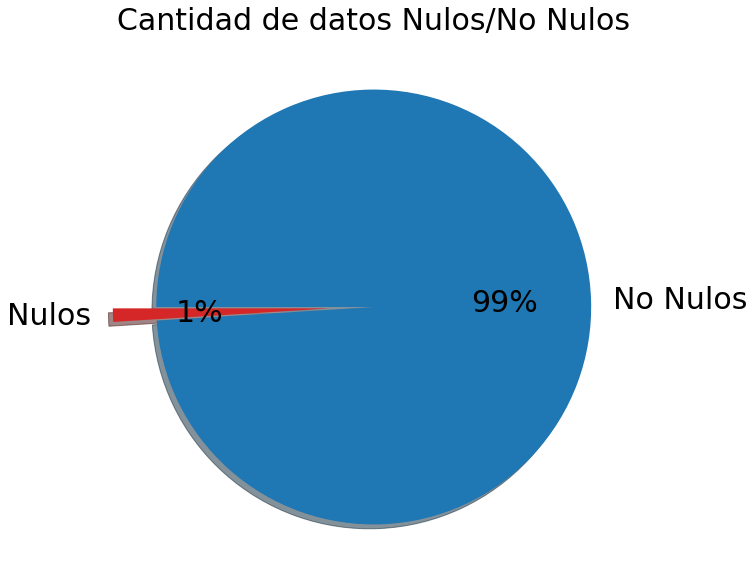

In [100]:
plt.figure(figsize=(10,10))

x = [207, 20640]
labels = ['Nulos', 'No Nulos']
colors = [ 'tab:red','tab:blue']
explode = [ 0.2, 0]
plt.pie(x, labels = labels,textprops={"fontsize":30},
          colors = colors,
          autopct='%.0f%%',
          explode = explode,
          shadow = True,
          startangle = 180)
plt.title('Cantidad de datos Nulos/No Nulos', fontsize = 30)
plt.show()

Vamos a separar las propiedades "bodega" de las otras:

In [101]:
bodegas=housing[housing["total_bedrooms"].isnull()]
housing_new=housing.dropna(subset=["total_bedrooms"])
print(housing_new.describe())

          longitude      latitude  housing_median_age   total_rooms  \
count  20433.000000  20433.000000        20433.000000  20433.000000   
mean    -119.570689     35.633221           28.633094   2636.504233   
std        2.003578      2.136348           12.591805   2185.269567   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1450.000000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.720000           37.000000   3143.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20433.000000  20433.000000   20433.000000   
mean       537.870553   1424.946949    499.433465       3.871162   
std        421.385070   1133.208490    382.299226       1.899291   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.00000

Veamos la correlacion existente entre pares de columnas:

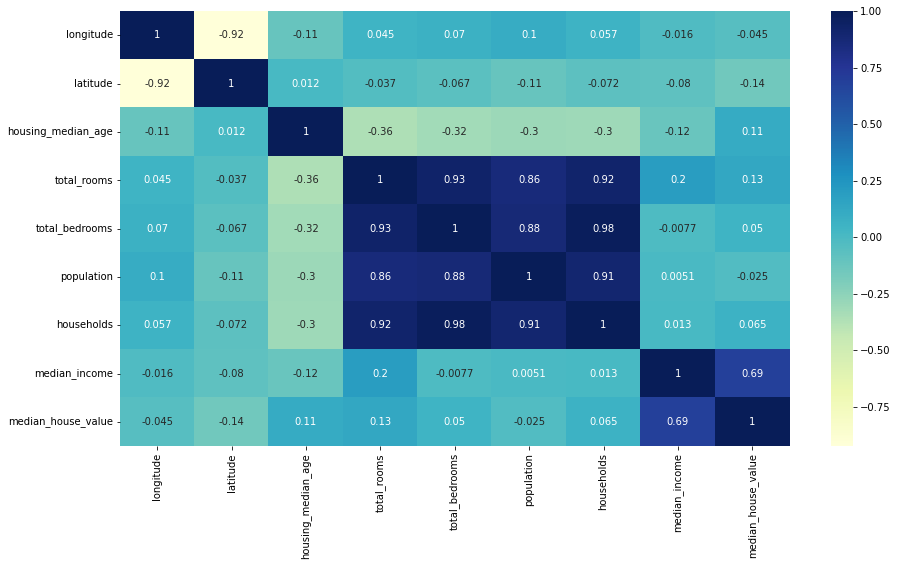

In [102]:
plt.figure(figsize=(15, 8))
sns.heatmap(
    housing_new.corr(),
    annot=True,
    cmap="YlGnBu"
)

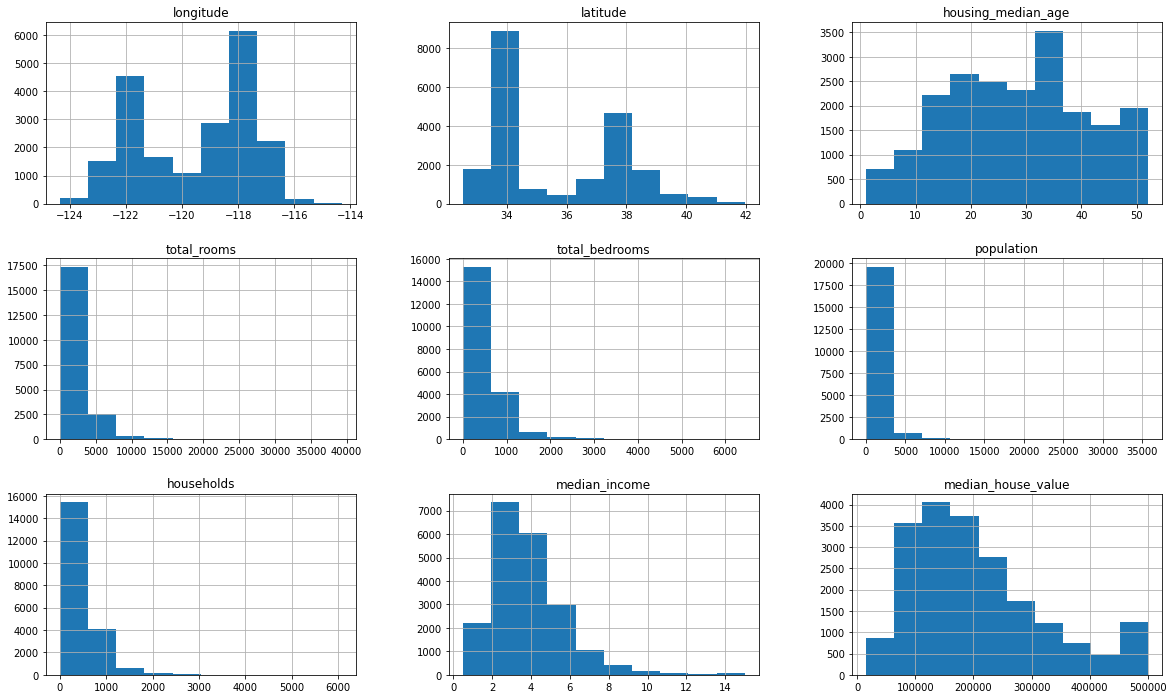

In [103]:
housing_new.hist(figsize=(20, 12))
plt.show()

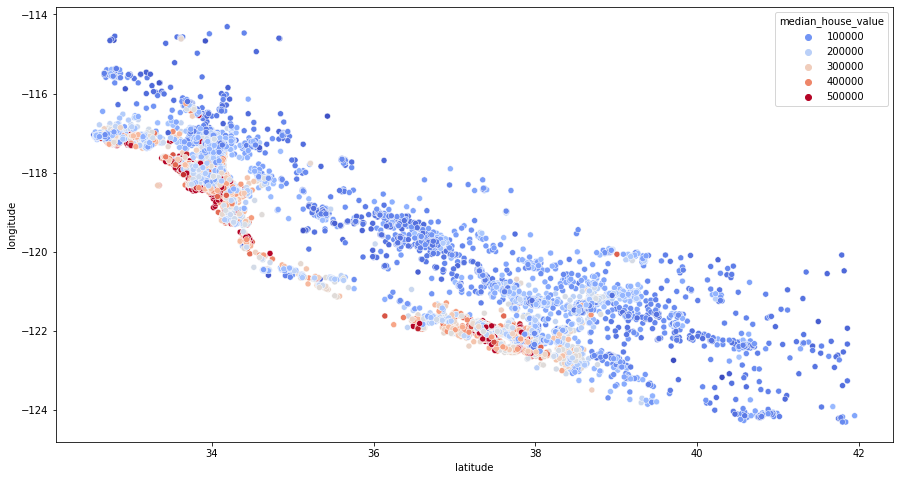

In [9]:
X = housing_new.drop(['median_house_value'], axis=1)
y = housing_new['median_house_value']

X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.3)
train_data = X_train.join(y_train)
test_data=X_test.join(y_test)

plt.figure(figsize=(15, 8))
sns.scatterplot(
    data=train_data,
    x="latitude",
    y="longitude",
    hue="median_house_value",
    palette="coolwarm"
)

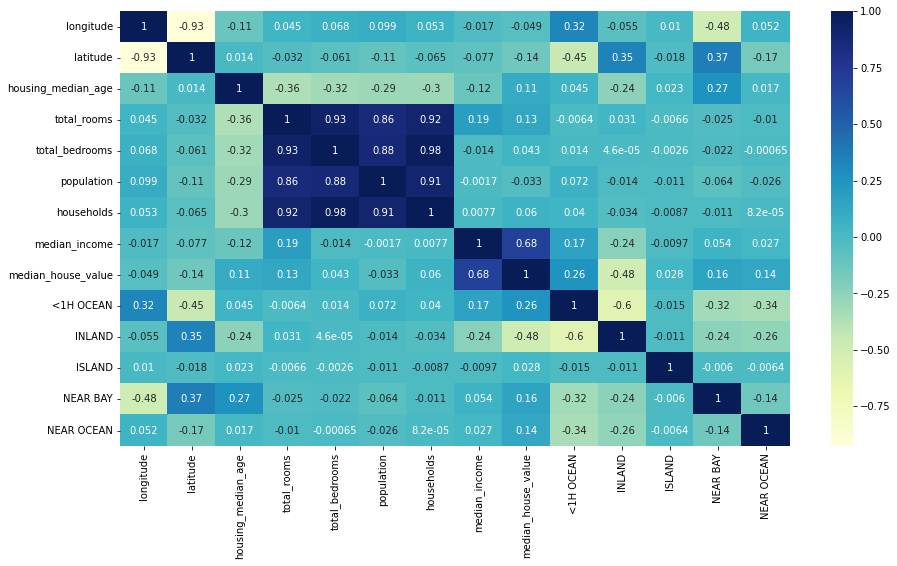

In [10]:
train_data_num = train_data.join(pd.get_dummies(train_data.ocean_proximity)).drop(['ocean_proximity'], axis=1)
test_data_num = test_data.join(pd.get_dummies(test_data.ocean_proximity)).drop(['ocean_proximity'], axis=1)
plt.figure(figsize=(15, 8))
sns.heatmap(
    train_data_num.corr(),
    annot=True,
    cmap="YlGnBu"
)

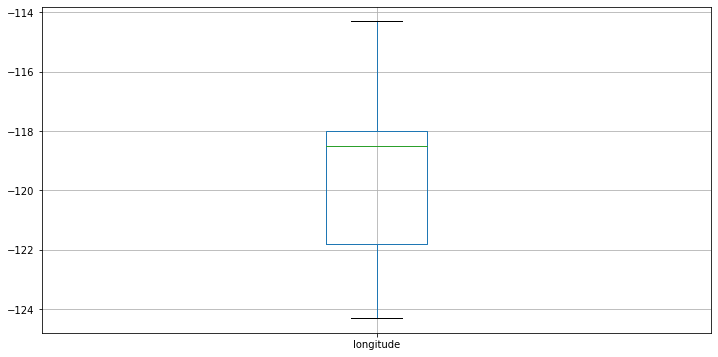

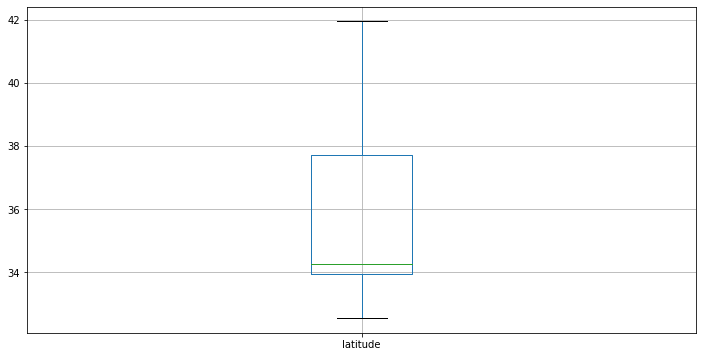

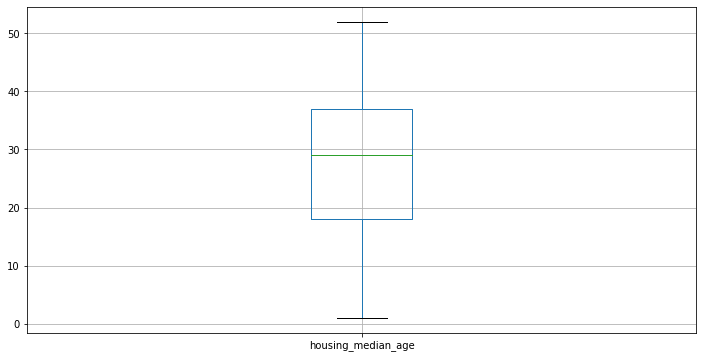

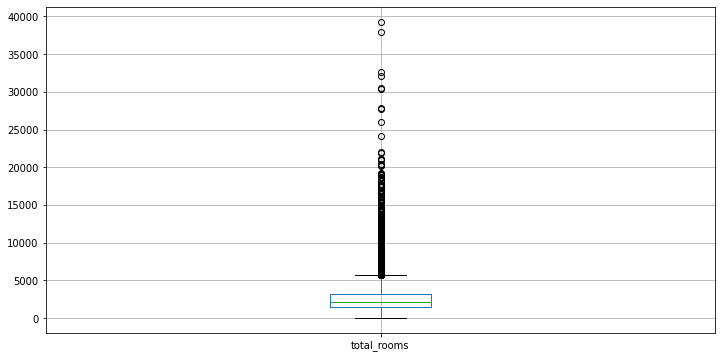

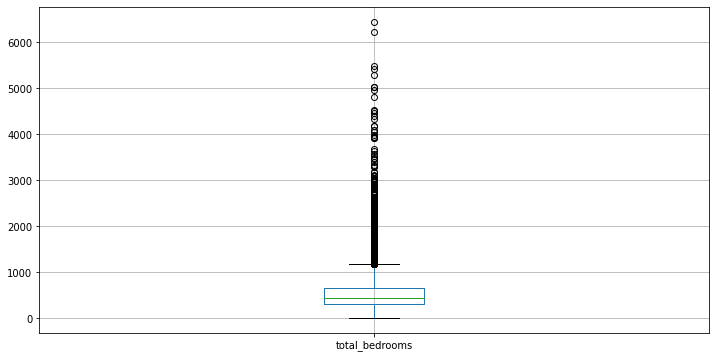

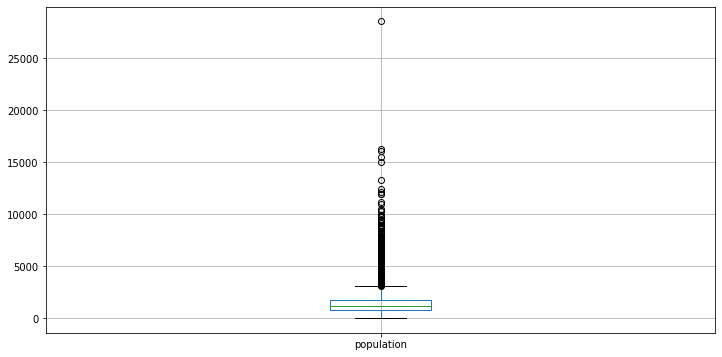

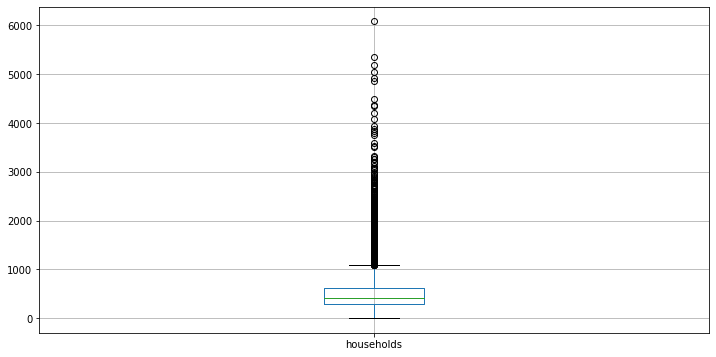

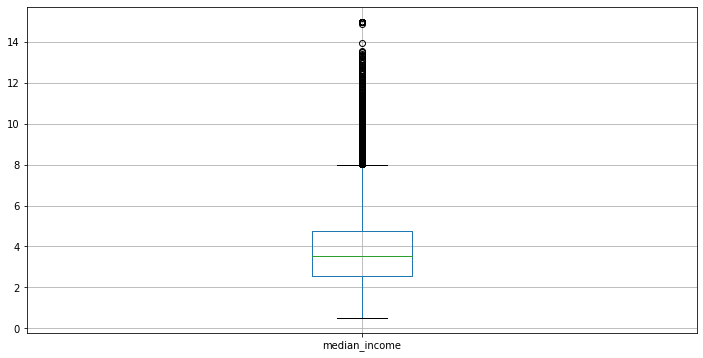

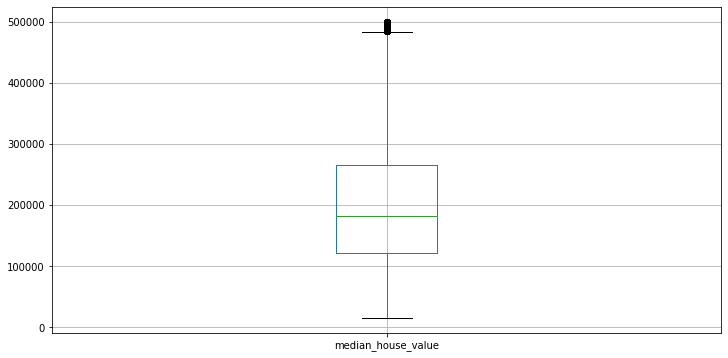

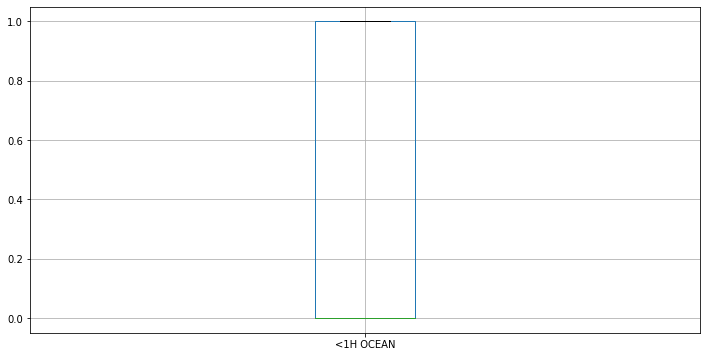

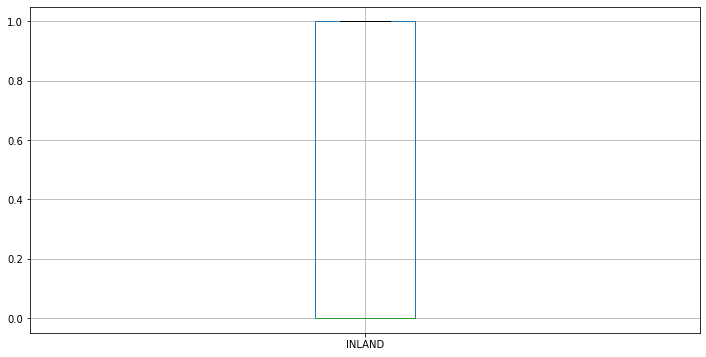

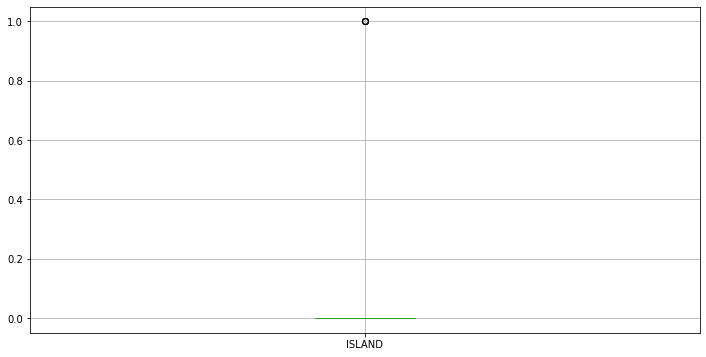

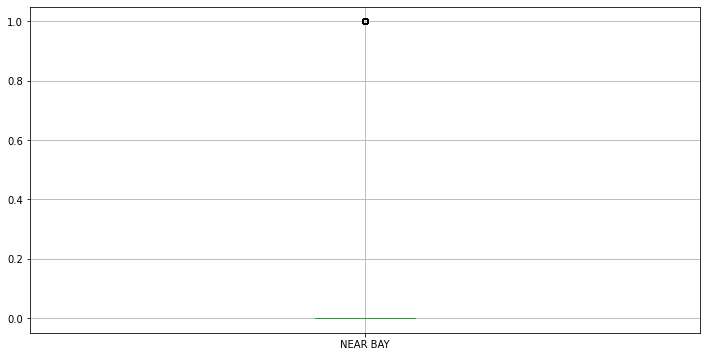

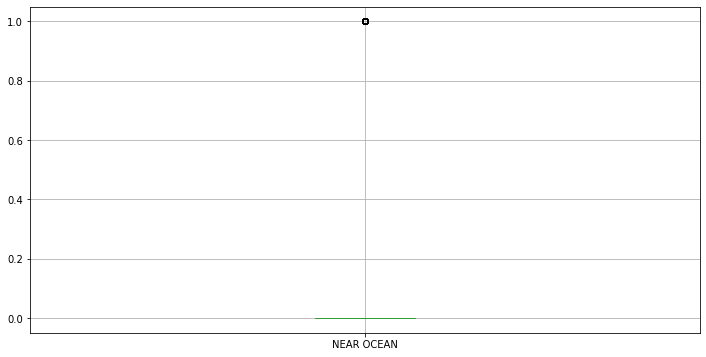

In [110]:
for column in train_data_num:
    plt.figure(figsize=(12,6))
    train_data_num.boxplot([column])


Se aprecia que en ciertas columnas se presentan outliers, sin embargo estos no los eliminaremos, pues presentan importancia para el objetivo.

In [11]:
scaler = StandardScaler()
X_train_n, y_train_n = train_data_num.drop(['median_house_value'], axis=1), train_data_num['median_house_value']
X_train_n = scaler.fit_transform(X_train_n)
X_test_n, y_test_n = test_data_num.drop(['median_house_value'], axis=1), test_data_num['median_house_value']
X_test_n = scaler.fit_transform(X_test_n)

In [111]:

#Selección de hiperparámetros
params_knn = {
          'n_neighbors' : [20, 3, 6,9,24,13,17 ],
          'weights' : ['uniform', 'distance'],
          'metric' : ['euclidean', 'manhattan',"minkowski"],
          'algorithm' : ['auto','ball_tree', 'kd_tree']
          }

model_knn = KNeighborsClassifier()


model_kn = GridSearchCV(estimator = model_knn, param_grid = params_knn, cv = 10)

start_time = time.time()
model_kn = model_kn.fit(X_train_n, y_train_n)


print("--- %s segundos ---" % (time.time() - start_time))

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


--- 439.32917380332947 segundos ---


In [113]:
print("Mejor: %f usando %s" % (model_kn.best_score_, model_kn.best_params_))
y_pred = model_kn.predict(X_test_n)
summary_metrics(pd.DataFrame(data={'y':y_test_n, 'yhat':y_pred}))

Mejor: 0.041180 usando {'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 24, 'weights': 'distance'}


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,accuracy,recall,precision,fscore
0,0.0411,0.0009,0.0006,0.0007


Claramente, el modelo de k-vecinos mas cercanos se ajusta de manera pesima al conjunto de entrenamiento, por lo que luego entrega valores de las metricas infimos y predicciones no acertadas.

In [15]:
# Linear Regression
fit_intercepts = [True, False]
param_grid_linear = dict(fit_intercept=fit_intercepts)
linear_model = LinearRegression()

# Decision Tree
min_tree_splits = range(2,3)
min_tree_leaves = range(2,3)
param_grid_tree = dict(min_samples_split=min_tree_splits,
                       min_samples_leaf=min_tree_leaves)
tree_model = DecisionTreeRegressor()
# Random Forest
estimators_space = [100]
min_sample_splits = range(2,4)
min_sample_leaves = range(2,3)
param_grid_forest = dict(min_samples_split=min_sample_splits,
                       min_samples_leaf=min_sample_leaves,
                       n_estimators=estimators_space)
forest_model = RandomForestRegressor()

cv = 5

models_to_test = ['LinearRegression','DecisionTreeRegressor','RandomForest']
regression_dict = dict(LinearRegression=linear_model,
                       DecisionTreeRegressor=tree_model,
                       RandomForest=forest_model)
param_grid_dict = dict(LinearRegression=param_grid_linear,
                       DecisionTreeRegressor=param_grid_tree,
                       RandomForest=param_grid_forest)
score_dict = {}
params_dict = {}
mae_dict = {}
mse_dict = {}
r2_dict = {}
best_est_dict = {}

for model in models_to_test:
  regressor = GridSearchCV(regression_dict[model], param_grid_dict[model], cv=cv, n_jobs=-1)

  regressor.fit(X_train_n, y_train_n)
  y_pred = regressor.predict(X_test_n)

  # Print the tuned parameters and score
  print(" === Start report for regressor {} ===".format(model))
  score_dict[model] = regressor.best_score_
  print("Hiperparameters: {}".format(regressor.best_params_)) 
  params_dict = regressor.best_params_
  print("Best score is {}".format(regressor.best_score_))
# Compute metrics
  mae_dict[model] = mean_absolute_error(y_test_n, y_pred)
  print("MAE for {}".format(model))
  print(mean_absolute_error(y_test_n, y_pred))
  mse_dict[model] = mean_squared_error(y_test_n, y_pred)
  print("MSE for {}".format(model))
  print(mean_squared_error(y_test_n, y_pred))
  r2_dict[model] = r2_score(y_test_n, y_pred)
  print("R2 score for {}".format(model))
  print(r2_score(y_test_n, y_pred))
  print(" === End of report for regressor {} === \n".format(model))
  
  # Add best estimator to the dict
  best_est_dict[model] = regressor.best_estimator_

 === Start report for regressor LinearRegression ===
Hiperparameters: {'fit_intercept': True}
Best score is 0.6412674425180672
MAE for LinearRegression
49741.12951846807
MSE for LinearRegression
4595057584.901848
R2 score for LinearRegression
0.6542382629242312
 === End of report for regressor LinearRegression === 

 === Start report for regressor DecisionTreeRegressor ===
Hiperparameters: {'min_samples_leaf': 2, 'min_samples_split': 2}
Best score is 0.6535409351057433
MAE for DecisionTreeRegressor
48301.41079390974
MSE for DecisionTreeRegressor
5307662817.91862
R2 score for DecisionTreeRegressor
0.6006172541197408
 === End of report for regressor DecisionTreeRegressor === 

 === Start report for regressor RandomForest ===
Hiperparameters: {'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best score is 0.8105111767598572
MAE for RandomForest
36340.031015845096
MSE for RandomForest
2924763956.21779
R2 score for RandomForest
0.779921916678208
 === End of report for reg

Finalmente, el modelo de regresion que mejor resultado nos presenta es el de RandomForest, en particular con la menor metrica "MAE". Por otro lado, como la metrica R2 score es ciertamente cercana a el valor 1 podemos concluir que el modelo se ajusta bien. 